In [1]:
# !python3 -m pip install pandas numpy scikit-learn xgboost matplotlib

In [2]:
# Dependencies
import pandas as pd
import numpy as np
from collections import Counter

In [3]:
from fdt import FDT

In [4]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import xgboost as xgb
import matplotlib.pyplot as plt

## Classification Evaluation

In [5]:
breast_cancer = datasets.load_breast_cancer(as_frame=True)
breast_cancer.data.shape, type(breast_cancer['data'])

((569, 30), pandas.core.frame.DataFrame)

In [6]:
X = breast_cancer['data']
Y = list(breast_cancer['target'])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [7]:
clf = RandomForestClassifier()
clf.fit(X_train, Y_train)

RandomForestClassifier()

In [8]:
xgbclf = xgb.XGBClassifier()
xgbclf.fit(X_train, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [9]:
# Initiate and train the federated decision tree
root = FDT(X_train, Y_train).grow_tree()

In [10]:
def evaluate_test(root, verbose = True):
    Xsubset = X_test.copy()
    Xsubset['y'] = Y_test
    Xsubset['yhat'] = root.predict(X_test)
    c = sum(Xsubset['y'] == Xsubset['yhat'])
    n = len(Y_test)
    if verbose:
        print("Y_test distribution:", Counter(Y_test))
        print("Y_pred distribution:", Counter(Xsubset['yhat']))
        print("Accuracy:", c, "/", n, "=", c / n)
    else:
        return c / n

In [11]:
class BoostClassifier:
    def __init__(self, roots):
        self.roots = roots
    def predict(self, X_test):
        tmp = [root.predict(X_test) for root in roots]
        return np.round(np.average(tmp, axis=0))

In [12]:
evaluate_test(clf)
skbase = evaluate_test(clf, verbose = False)

Y_test distribution: Counter({1: 71, 0: 43})
Y_pred distribution: Counter({1: 73, 0: 41})
Accuracy: 110 / 114 = 0.9649122807017544


In [13]:
evaluate_test(xgbclf)
xgbbase = evaluate_test(xgbclf, verbose = False)

Y_test distribution: Counter({1: 71, 0: 43})
Y_pred distribution: Counter({1: 72, 0: 42})
Accuracy: 109 / 114 = 0.956140350877193


In [14]:
evaluate_test(root)
base = evaluate_test(root, verbose = False)

Y_test distribution: Counter({1: 71, 0: 43})
Y_pred distribution: Counter({1: 70, 0: 44})
Accuracy: 107 / 114 = 0.9385964912280702


In [15]:
limit = 20

In [16]:
n = len(Y_train)
result_sep = []
result_merge = []
result_model = []
result_boost = []
count_boost = []
for separate_n in range(2, limit):
    seg = n // separate_n
    roots = []
    for i in range(separate_n):
        X_train_tmp, Y_train_tmp = X_train.head((i+1) * seg).tail(seg), Y_train[i*seg:(i+1)*seg]
        root_tmp = FDT(X_train_tmp, Y_train_tmp).grow_tree()
        roots.append(root_tmp)
    result_tmp = [evaluate_test(root_tmp, verbose = False) for root_tmp in roots]
    result_sep.append(result_tmp)
    bc = BoostClassifier(roots)
    result_boost.append(evaluate_test(bc, verbose = False))
    count_boost.append(sum([r.get_stats()["count"] for r in roots]))
    for root_tmp in roots[1:]:
        roots[0].merge(root_tmp)
    result_tmp = evaluate_test(roots[0], verbose = False)
    print(separate_n, ":", result_tmp)
    result_merge.append(result_tmp)
    result_model.append(roots[0])

2 : 0.956140350877193
3 : 0.956140350877193
4 : 0.9035087719298246
5 : 0.9122807017543859
6 : 0.9210526315789473
7 : 0.9473684210526315
8 : 0.9298245614035088
9 : 0.9385964912280702
10 : 0.9649122807017544
11 : 0.9385964912280702
12 : 0.9649122807017544
13 : 0.956140350877193
14 : 0.9385964912280702
15 : 0.956140350877193
16 : 0.9210526315789473
17 : 0.9298245614035088
18 : 0.9035087719298246
19 : 0.9473684210526315


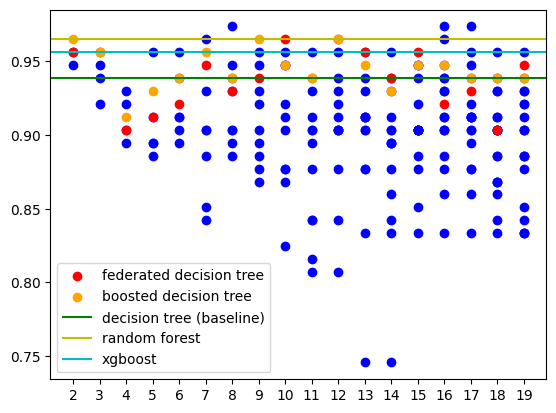

In [17]:
plt.figure()
for separate_n in range(2, limit):
    plt.scatter(x=np.ones(separate_n)*separate_n, y=result_sep[separate_n-2], c="b")
plt.scatter(x=range(2, limit), y=result_merge, c="r", label="federated decision tree")
plt.scatter(x=range(2, limit), y=result_boost, c="orange", label="boosted decision tree")
plt.axhline(y = base, color = 'g', linestyle = '-', label="decision tree (baseline)")
plt.axhline(y = skbase, color = 'y', linestyle = '-', label="random forest")
plt.axhline(y = xgbbase, color = 'c', linestyle = '-', label="xgboost")
plt.xticks(range(2, limit), range(2, limit))
plt.legend()
plt.show()

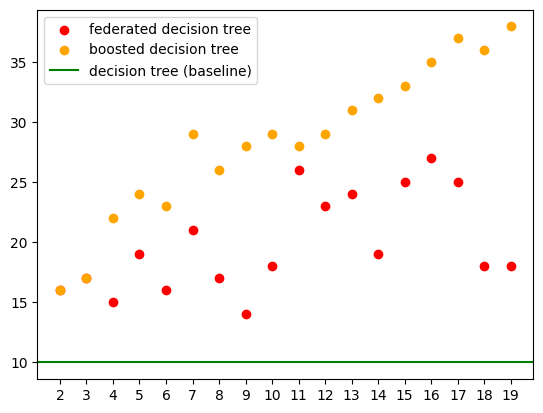

In [18]:
plt.figure()
plt.scatter(x=range(2, limit), y=[r.get_stats()["count"] for r in result_model], c="r", label="federated decision tree")
plt.scatter(x=range(2, limit), y=count_boost, c="orange", label="boosted decision tree")
plt.axhline(y = root.get_stats()["count"], color = 'g', linestyle = '-', label="decision tree (baseline)")
plt.xticks(range(2, limit), range(2, limit))
plt.legend()
plt.show()

## Regression Evaluation

In [19]:
diabetes = datasets.load_diabetes(as_frame=True)
print(diabetes.data.shape)

(442, 10)


In [20]:
X = diabetes['data']
Y = list(diabetes['target'])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [21]:
reg = RandomForestRegressor()
reg.fit(X_train, Y_train)

RandomForestRegressor()

In [22]:
xgbreg = xgb.XGBRegressor()
xgbreg.fit(X_train, Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [23]:
# Initiate and train the federated decision tree
root = FDT(X_train, Y_train, algo_type="regression").grow_tree()

In [24]:
def evaluate_reg(root, verbose = True):
    Xsubset = X_test.copy()
    Xsubset['y'] = Y_test
    Xsubset['yhat'] = root.predict(X_test)
    n = len(Y_test)
    c = sum((Xsubset['y'] - Xsubset['yhat']) ** 2)
    if verbose:
        print("Y_test mean:", np.mean(Y_test))
        print("Y_pred mean:", np.mean(Xsubset['yhat']))
        print("MSE:", c / n)
    else:
        return c / n

In [25]:
class BoostRegressor:
    def __init__(self, roots):
        self.roots = roots
    def predict(self, data):
        tmp = [root.predict(data) for root in roots]
        return np.average(tmp, axis=0)

In [26]:
evaluate_reg(reg)
skbase = evaluate_reg(reg, verbose = False)

Y_test mean: 145.77528089887642
Y_pred mean: 146.91516853932586
MSE: 2961.6630550561795


In [27]:
evaluate_reg(xgbreg)
xgbbase = evaluate_reg(xgbreg, verbose = False)

Y_test mean: 145.77528089887642
Y_pred mean: 142.45105
MSE: 4087.1214512491165


In [28]:
evaluate_reg(root)
base = evaluate_reg(root, verbose = False)

Y_test mean: 145.77528089887642
Y_pred mean: 145.801357943164
MSE: 3378.0333901728704


In [29]:
limit = 15

In [30]:
n = len(Y_train)
result_sep = []
result_merge = []
result_model = []
result_boost = []
count_boost = []
for separate_n in range(2, limit):
    seg = n // separate_n
    roots = []
    for i in range(separate_n):
        X_train_tmp, Y_train_tmp = X_train.head((i+1) * seg).tail(seg), Y_train[i*seg:(i+1)*seg]
        root_tmp = FDT(X_train_tmp, Y_train_tmp, algo_type="regression").grow_tree()
        roots.append(root_tmp)
    result_tmp = [evaluate_reg(root_tmp, verbose = False) for root_tmp in roots]
    result_sep.append(result_tmp)
    br = BoostRegressor(roots)
    result_boost.append(evaluate_reg(br, verbose = False))
    count_boost.append(sum([r.get_stats()["count"] for r in roots]))
    for root_tmp in roots[1:]:
        roots[0].merge(root_tmp)
    result_tmp = evaluate_reg(roots[0], verbose = False)
    print(separate_n, ":", result_tmp)
    result_merge.append(result_tmp)
    result_model.append(roots[0])

2 : 3167.5522842796263
3 : 2909.0421513631763
4 : 3060.5962080277027
5 : 2928.879266317614
6 : 2566.7566273306293
7 : 2926.359013160933
8 : 2999.5242651195495
9 : 2711.9498414841705
10 : 3056.0395450443452
11 : 3204.129775179402
12 : 3141.4288675921325
13 : 3255.7641331779305
14 : 3137.324478038555


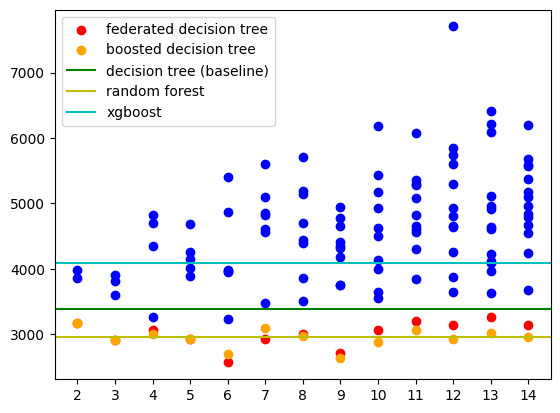

In [31]:
plt.figure()
for separate_n in range(2, limit):
    plt.scatter(x=np.ones(separate_n)*separate_n, y=result_sep[separate_n-2], c="b")
plt.scatter(x=range(2, limit), y=result_merge, c="r", label="federated decision tree")
plt.scatter(x=range(2, limit), y=result_boost, c="orange", label="boosted decision tree")
plt.axhline(y = base, color = 'g', linestyle = '-', label="decision tree (baseline)")
plt.axhline(y = skbase, color = 'y', linestyle = '-', label="random forest")
plt.axhline(y = xgbbase, color = 'c', linestyle = '-', label="xgboost")
plt.xticks(range(2, limit), range(2, limit))
plt.legend()
plt.show()

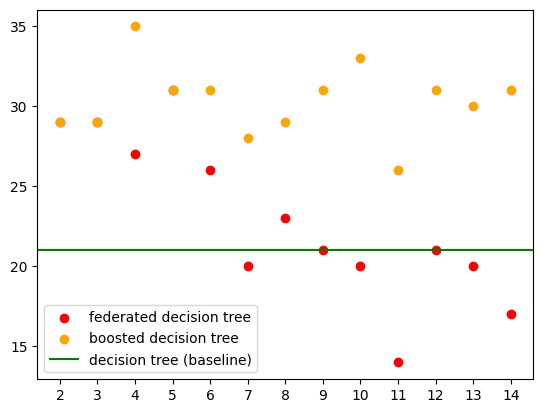

In [32]:
plt.figure()
plt.scatter(x=range(2, limit), y=[r.get_stats()["count"] for r in result_model], c="r", label="federated decision tree")
plt.scatter(x=range(2, limit), y=count_boost, c="orange", label="boosted decision tree")
plt.axhline(y = root.get_stats()["count"], color = 'g', linestyle = '-', label="decision tree (baseline)")
plt.xticks(range(2, limit), range(2, limit))
plt.legend()
plt.show()